In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import time
import pandas as pd
from multiprocessing import Pool, Manager
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import col, count, lit, abs as F_abs, broadcast
from pyspark.storagelevel import StorageLevel
import networkx as nx
import matplotlib.pyplot as plt

# Second crawler version (putting the crawled edges to a set to remove any dupped edge and saved in a dataframe)

In [ ]:
def is_valid_url(url, domain="it.tdtu.edu.vn"):
    """Check if URL is within the domain and not a static file."""
    parsed = urlparse(url)
    if domain not in parsed.netloc:
        return False
    # Exclude static files
    static_extensions = ('.jpg', '.png', '.gif', '.pdf', '.css', '.js', '.ico', '.mp4', '.mp3')
    return not url.lower().endswith(static_extensions)

def crawl_website(start_url, output_csv="url_pairs.csv"):
    """Crawl the website, collect unique (source, destination) URL pairs, and save to CSV."""
    visited = set()
    to_visit = [start_url]
    url_pairs = set()  # Use a set to avoid duplicate edges
    headers = {'User-Agent': 'Mozilla/5.0'}

    while to_visit:
        current_url = to_visit.pop(0)
        if current_url in visited:
            continue

        try:
            response = requests.get(current_url, headers=headers, timeout=5)
            if response.status_code != 200:
                continue
            soup = BeautifulSoup(response.text, 'html.parser')
            visited.add(current_url)

            # Extract all links
            for link in soup.find_all('a', href=True):
                href = link['href']
                absolute_url = urljoin(current_url, href).split('#')[0]  # Remove fragments
                if is_valid_url(absolute_url):
                    url_pairs.add((current_url, absolute_url))  # Add edge as a tuple to the set
                    if absolute_url not in visited and absolute_url not in to_visit:
                        to_visit.append(absolute_url)

            print(f"Crawled: {current_url}, Total unique links found so far: {len(url_pairs)}")
            time.sleep(1)  # Be polite to the server

        except Exception as e:
            print(f"Error crawling {current_url}: {e}")

    # Save URL pairs to CSV
    if url_pairs:
        df = pd.DataFrame(list(url_pairs), columns=['source', 'destination'])
        df.to_csv(output_csv, index=False, encoding='utf-8')
        print(f"Saved {len(url_pairs)} unique URL pairs to {output_csv}")
    else:
        print("No URL pairs collected. CSV file not created.")

    return url_pairs

# PageRank 2.0 (handles raw data in the 100s of gb range, updated crawling method for better crawling speed with distinct edges and nodes)

In [ ]:
# Visualization function for top 20 sites
def visualize_top_pages(edges_df, ranks_df, top_n=20, output_file="/content/top_pages_graph.png"):
    """Visualize top N pages by PageRank as a directed graph."""
    # Get top N pages
    top_pages = ranks_df.orderBy(col("rank").desc()).limit(top_n)
    top_pages_list = [row['page'] for row in top_pages.collect()]

    # Filter edges
    top_edges = edges_df.filter(
        col("source").isin(top_pages_list) & col("destination").isin(top_pages_list)
    ).collect()

    # Get ranks for sizing
    rank_dict = {row['page']: row['rank'] for row in top_pages.collect()}

    # Create graph
    G = nx.DiGraph()
    for page in top_pages_list:
        G.add_node(page, rank=rank_dict[page])
    for edge in top_edges:
        G.add_edge(edge['source'], edge['destination'])

    # Layout
    pos = nx.spring_layout(G, k=1.5, iterations=50)

    # Node sizes
    node_sizes = [rank_dict[page] * 100000 for page in G.nodes()]

    # Shorten labels
    labels = {page: page.split('/')[-2] if page.split('/')[-1] == '' else page.split('/')[-1] for page in G.nodes()}

    # Draw graph
    plt.figure(figsize=(12, 12))
    nx.draw(
        G, pos,
        with_labels=False,
        node_size=node_sizes,
        node_color='lightblue',
        font_size=8,
        font_weight='bold',
        arrows=True,
        arrowstyle='->',
        arrowsize=15,
        edge_color='gray'
    )
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')
    plt.title(f"Top {top_n} Pages by PageRank", fontsize=14)
    plt.savefig(output_file, format='png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Graph saved to {output_file}")

In [ ]:
# PageRank class
class PageRank:
    def __init__(self, edges_df, damping_factor=0.85, max_iter=10, tol=1e-4):
        self.edges_df = edges_df
        self.damping_factor = damping_factor
        self.max_iter = max_iter
        self.tol = tol
        self.spark = edges_df.sparkSession

    def compute_pagerank(self):
        self.spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoints")
        pages = self.edges_df.select("source").union(self.edges_df.select("destination")).distinct()
        N = pages.count()
        if N == 0:
            return self.spark.createDataFrame([], schema=StructType([
                StructField("page", StringType(), True),
                StructField("rank", StringType(), True)
            ]))
        ranks = pages.select(col("source").alias("page"), lit(1.0 / N).alias("rank"))
        ranks.persist(StorageLevel.MEMORY_AND_DISK)
        out_degrees = self.edges_df.groupBy("source").agg(count("destination").alias("out_degree"))
        out_degrees.persist(StorageLevel.MEMORY_AND_DISK)
        for iteration in range(self.max_iter):
            print(f"Iteration {iteration + 1}")
            contributions = self.edges_df.join(broadcast(ranks), self.edges_df.source == ranks.page) \
                .join(broadcast(out_degrees), self.edges_df.source == out_degrees.source) \
                .select(
                    self.edges_df.destination.alias("page"),
                    (col("rank") / col("out_degree")).alias("contribution")
                )
            new_ranks = contributions.groupBy("page").agg({"contribution": "sum"}) \
                .select(
                    col("page"),
                    (lit((1 - self.damping_factor) / N) + lit(self.damping_factor) * col("sum(contribution)")).alias("rank")
                )
            all_pages = pages.select(col("source").alias("page"))
            new_ranks = all_pages.join(new_ranks, "page", "left_outer") \
                .select(col("page"), col("rank").alias("new_rank"))
            new_ranks = new_ranks.na.fill({"new_rank": (1 - self.damping_factor) / N})
            diff = ranks.join(new_ranks, "page") \
                .select(F_abs(col("rank") - col("new_rank")).alias("diff")) \
                .agg({"diff": "max"}).collect()[0][0]
            print(f"Max rank difference: {diff}")
            if diff < self.tol:
                print("Converged.")
                break
            ranks = new_ranks.select(col("page"), col("new_rank").alias("rank"))
            if (iteration + 1) % 3 == 0:
                ranks = ranks.checkpoint()
        ranks.unpersist()
        out_degrees.unpersist()
        return ranks

In [ ]:
# Crawl the website and save to CSV
start_url = "https://it.tdtu.edu.vn"
url_pairs = crawl_website(start_url, output_csv="url_pairs.csv")
print(f"Total unique URL pairs collected: {len(url_pairs)}")
print("Sample pairs:", list(url_pairs)[:5])

Crawled: https://it.tdtu.edu.vn, Total unique links found so far: 44
Crawled: https://it.tdtu.edu.vn/en, Total unique links found so far: 80
Crawled: https://it.tdtu.edu.vn/giao-vien, Total unique links found so far: 99
Crawled: https://it.tdtu.edu.vn/, Total unique links found so far: 142
Crawled: https://it.tdtu.edu.vn/gioi-thieu, Total unique links found so far: 189
Crawled: https://it.tdtu.edu.vn/giao-duc, Total unique links found so far: 210
Crawled: https://it.tdtu.edu.vn/khoa-hoc-cong-nghe, Total unique links found so far: 235
Crawled: https://it.tdtu.edu.vn/tin-tuc-khoa, Total unique links found so far: 268
Crawled: https://it.tdtu.edu.vn/doanh-nghiep, Total unique links found so far: 288
Crawled: https://it.tdtu.edu.vn/tuyen-sinh, Total unique links found so far: 310
Crawled: https://it.tdtu.edu.vn/it-career-day-2025, Total unique links found so far: 326
Crawled: https://it.tdtu.edu.vn/iccies, Total unique links found so far: 327
Crawled: https://it.tdtu.edu.vn/tuyen-sinh/thac

<ipython-input-2-c270b732ca3e>:26: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(response.text, 'html.parser')


Crawled: https://it.tdtu.edu.vn/taxonomy/term/68/feed, Total unique links found so far: 3306
Crawled: https://it.tdtu.edu.vn/taxonomy/term/65, Total unique links found so far: 3344
Crawled: https://it.tdtu.edu.vn/user/login?destination=/khai-mac-giai-bong-da-khoa-cong-nghe-thong-tin-khoa-my-thuat-cong-nghiep-nam-2025%23comment-form, Total unique links found so far: 3361
Crawled: https://it.tdtu.edu.vn/user/login?destination=/ngay-hoi-sinh-vien-it-doanh-nghiep-it-career-day-2025-ket-noi-va-dinh-huong-tuong-lai%23comment-form, Total unique links found so far: 3378
Crawled: https://it.tdtu.edu.vn/taxonomy/term/85, Total unique links found so far: 3400
Crawled: https://it.tdtu.edu.vn/user/login?destination=/sinh-vien-khoa-cong-nghe-thong-tin-tham-quan-kien-tap-tai-cong-ty-netcompany-732025%23comment-form, Total unique links found so far: 3417
Crawled: https://it.tdtu.edu.vn/taxonomy/term/93, Total unique links found so far: 3438
Crawled: https://it.tdtu.edu.vn/user/login?destination=/doi-o

In [ ]:
# Initialize Spark session for large datasets
spark = SparkSession.builder \
    .appName("PageRankLargeDataset") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.sql.shuffle.partitions", "1000") \
    .config("spark.memory.fraction", "0.75") \
    .config("spark.shuffle.memoryFraction", "0.3") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.default.parallelism", "1000") \
    .getOrCreate()

# Load CSV into DataFrame
schema = StructType([
    StructField("source", StringType(), True),
    StructField("destination", StringType(), True)
])

In [ ]:
edges_df = spark.read.csv("/content/url_pairs.csv", header=True, schema=schema)

# Deduplicate and persist to disk
edges_df = edges_df.dropDuplicates(["source", "destination"]) \
    .repartition(1000, "source")
edges_df.persist(StorageLevel.DISK_ONLY)
edges_df.show(5)
print(f"Total edges: {edges_df.count()}")

+--------------------+--------------------+
|              source|         destination|
+--------------------+--------------------+
|http://it.tdtu.ed...|http://it.tdtu.ed...|
|http://it.tdtu.ed...|http://it.tdtu.ed...|
|http://it.tdtu.ed...|http://it.tdtu.ed...|
|http://it.tdtu.ed...|http://it.tdtu.ed...|
|http://it.tdtu.ed...|http://it.tdtu.ed...|
+--------------------+--------------------+
only showing top 5 rows

Total edges: 75970


Iteration 1
Max rank difference: 0.024039269132932313
Iteration 2
Max rank difference: 0.007830757936579167
Iteration 3
Max rank difference: 0.0015235374912797124
Iteration 4
Max rank difference: 0.0012869012914389997
Iteration 5
Max rank difference: 0.0007296764454920914
Iteration 6
Max rank difference: 0.0005344415428524645
Iteration 7
Max rank difference: 0.0003763324780487465
Iteration 8
Max rank difference: 0.00028796616593325733
Iteration 9
Max rank difference: 0.00022013651547688265
Iteration 10
Max rank difference: 0.000168713821379049


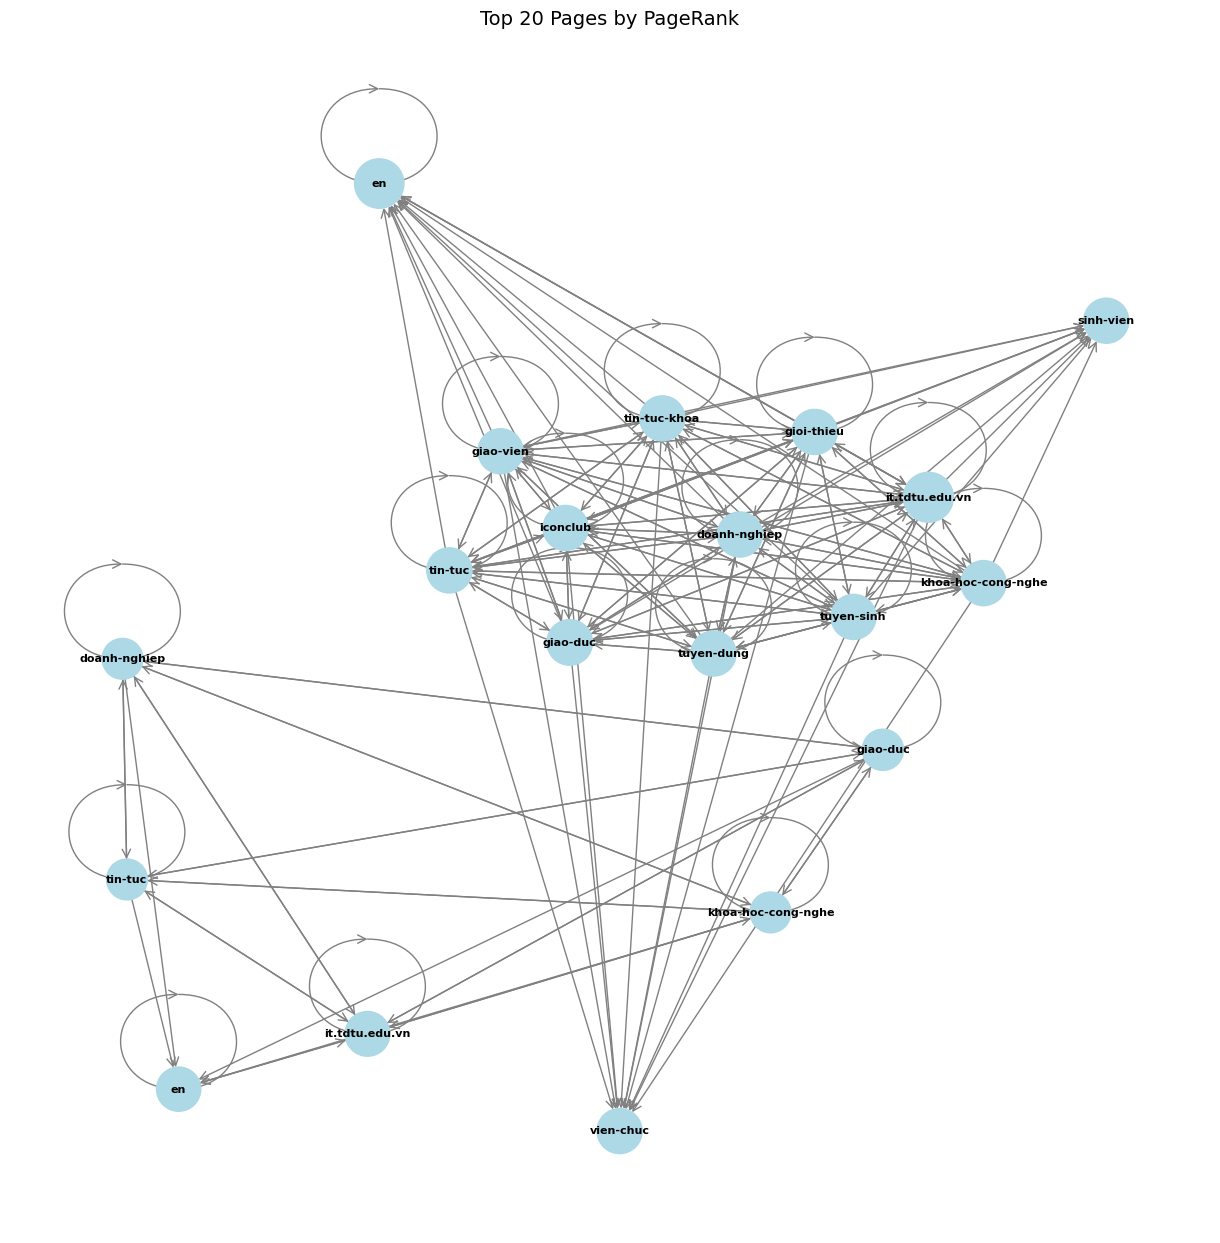

Graph saved to /content/top_pages_graph.png
+--------------------+--------------------+
|                page|                rank|
+--------------------+--------------------+
|https://it.tdtu.e...|0.012932930665217364|
|https://it.tdtu.e...|0.012668884846609694|
|https://it.tdtu.e...| 0.01077353804694107|
|https://it.tdtu.e...|0.010551937566500517|
|https://it.tdtu.e...|0.010551937566500517|
|https://it.tdtu.e...|0.010551937566500517|
|https://it.tdtu.e...|0.010551937566500517|
|https://it.tdtu.e...|0.010551937566500517|
|https://it.tdtu.e...|0.010551937566500517|
|https://it.tdtu.e...|0.010551937566500517|
|https://it.tdtu.e...|0.010551937566500517|
|https://it.tdtu.e...|0.010551937566500517|
|https://it.tdtu.e...|0.010551937566500517|
|https://it.tdtu.e...|0.010551937566500517|
|http://it.tdtu.ed...|  0.0103725711925697|
|http://it.tdtu.ed...|0.010154155789243032|
|http://it.tdtu.ed...|0.008817833432072356|
|http://it.tdtu.ed...|0.008642863820321733|
|http://it.tdtu.ed...|0.00864286

In [ ]:
# Compute PageRank
pagerank = PageRank(edges_df)
ranks_df = pagerank.compute_pagerank()

# Visualize top 20 pages
visualize_top_pages(edges_df, ranks_df, top_n=20, output_file="/content/top_pages_graph.png")

# Sort and save results
ranks_df = ranks_df.orderBy(col("rank").desc()).cache()
ranks_df.write.csv("/content/pagerank_results", mode="overwrite")
ranks_df.show(20)

# Get most important page
most_important_page = ranks_df.limit(1).collect()[0]
print(f"Most important page: {most_important_page['page']} with rank {most_important_page['rank']}")

# Clean up
edges_df.unpersist()
spark.stop()